In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/dfgeopoli.csv")

In [27]:
# Load the data
df['year'] = pd.to_datetime(df['year'], format='%Y') #+ pd.offsets.YearEnd(0)
df['v2x_polyarchy_diff'] = abs(df['v2x_polyarchy_o'] - df['v2x_polyarchy_d'])
df['v2x_libdem_diff'] = abs(df['v2x_libdem_o'] - df['v2x_libdem_d'])
df['v2x_partipdem_diff'] = abs(df['v2x_partipdem_o'] - df['v2x_partipdem_d'])
df['v2x_delibdem_diff'] = abs(df['v2x_delibdem_o'] - df['v2x_delibdem_d'])
df['v2x_egaldem_diff'] = abs(df['v2x_egaldem_o'] - df['v2x_egaldem_d'])
df_final = df.drop(columns=[
    'v2x_polyarchy_o', 'v2x_polyarchy_d',
    'v2x_libdem_o', 'v2x_libdem_d',
    'v2x_partipdem_o', 'v2x_partipdem_d',
    'v2x_delibdem_o', 'v2x_delibdem_d',
    'v2x_egaldem_o', 'v2x_egaldem_d'])


df["all_exports_new"] = np.where(
    df["tradeflow_comtrade_o"].notna(), 
    df["tradeflow_comtrade_o"], 
    np.where(
        df["tradeflow_comtrade_d"].notna(), 
        df["tradeflow_comtrade_d"],
        np.nan
    )
)

df["log_all_exports_new"] = np.log1p(df["all_exports_new"])
df.head()

year country_id_o  country_o country_id_d    country_d  contig  \
0 1965-12-31          SGP  Singapore          AFG  Afghanistan       0   
1 1966-12-31          SGP  Singapore          AFG  Afghanistan       0   
2 1967-12-31          SGP  Singapore          AFG  Afghanistan       0   
3 1968-12-31          SGP  Singapore          AFG  Afghanistan       0   
4 1969-12-31          SGP  Singapore          AFG  Afghanistan       0   

   distcap    dist  comlang_off  comlang_ethno  ...  v2x_polyarchy_diff  \
0   5147.0  5147.0            0              0  ...               0.162   
1   5147.0  5147.0            0              0  ...               0.144   
2   5147.0  5147.0            0              0  ...               0.142   
3   5147.0  5147.0            0              0  ...               0.148   
4   5147.0  5147.0            0              0  ...               0.151   

   v2x_libdem_diff  v2x_partipdem_diff  v2x_delibdem_diff  v2x_egaldem_diff  \
0            0.160               0.035              0.114             0.174   
1            0.160               0.033              0.111             0.177   
2            0.159               0.033              0.110             0.176   
3            0.164               0.041              0.100             0.185   
4            0.166               0.042              0.101             0.187   

   geopolitical_closeness_index_fa  geopolitical_closeness_index_pca  \
0                        -0.684340                          0.886782   
1                        -0.701411                          0.919156   
2                        -0.700698                          0.786123   
3                        -0.687730                          0.873608   
4                        -0.667500                          0.738497   

   geopolitical_closeness_index_pls  all_exports_new  log_all_exports_new  
0                               NaN     1.812638e+06            14.410295  
1                               NaN     8.119700e+06            15.909804  
2                               NaN     8.423678e+06            15.946557  
3                               NaN     2.218523e+06            14.612353  
4                               NaN     1.523452e+06            14.236490  

[5 rows x 62 columns]

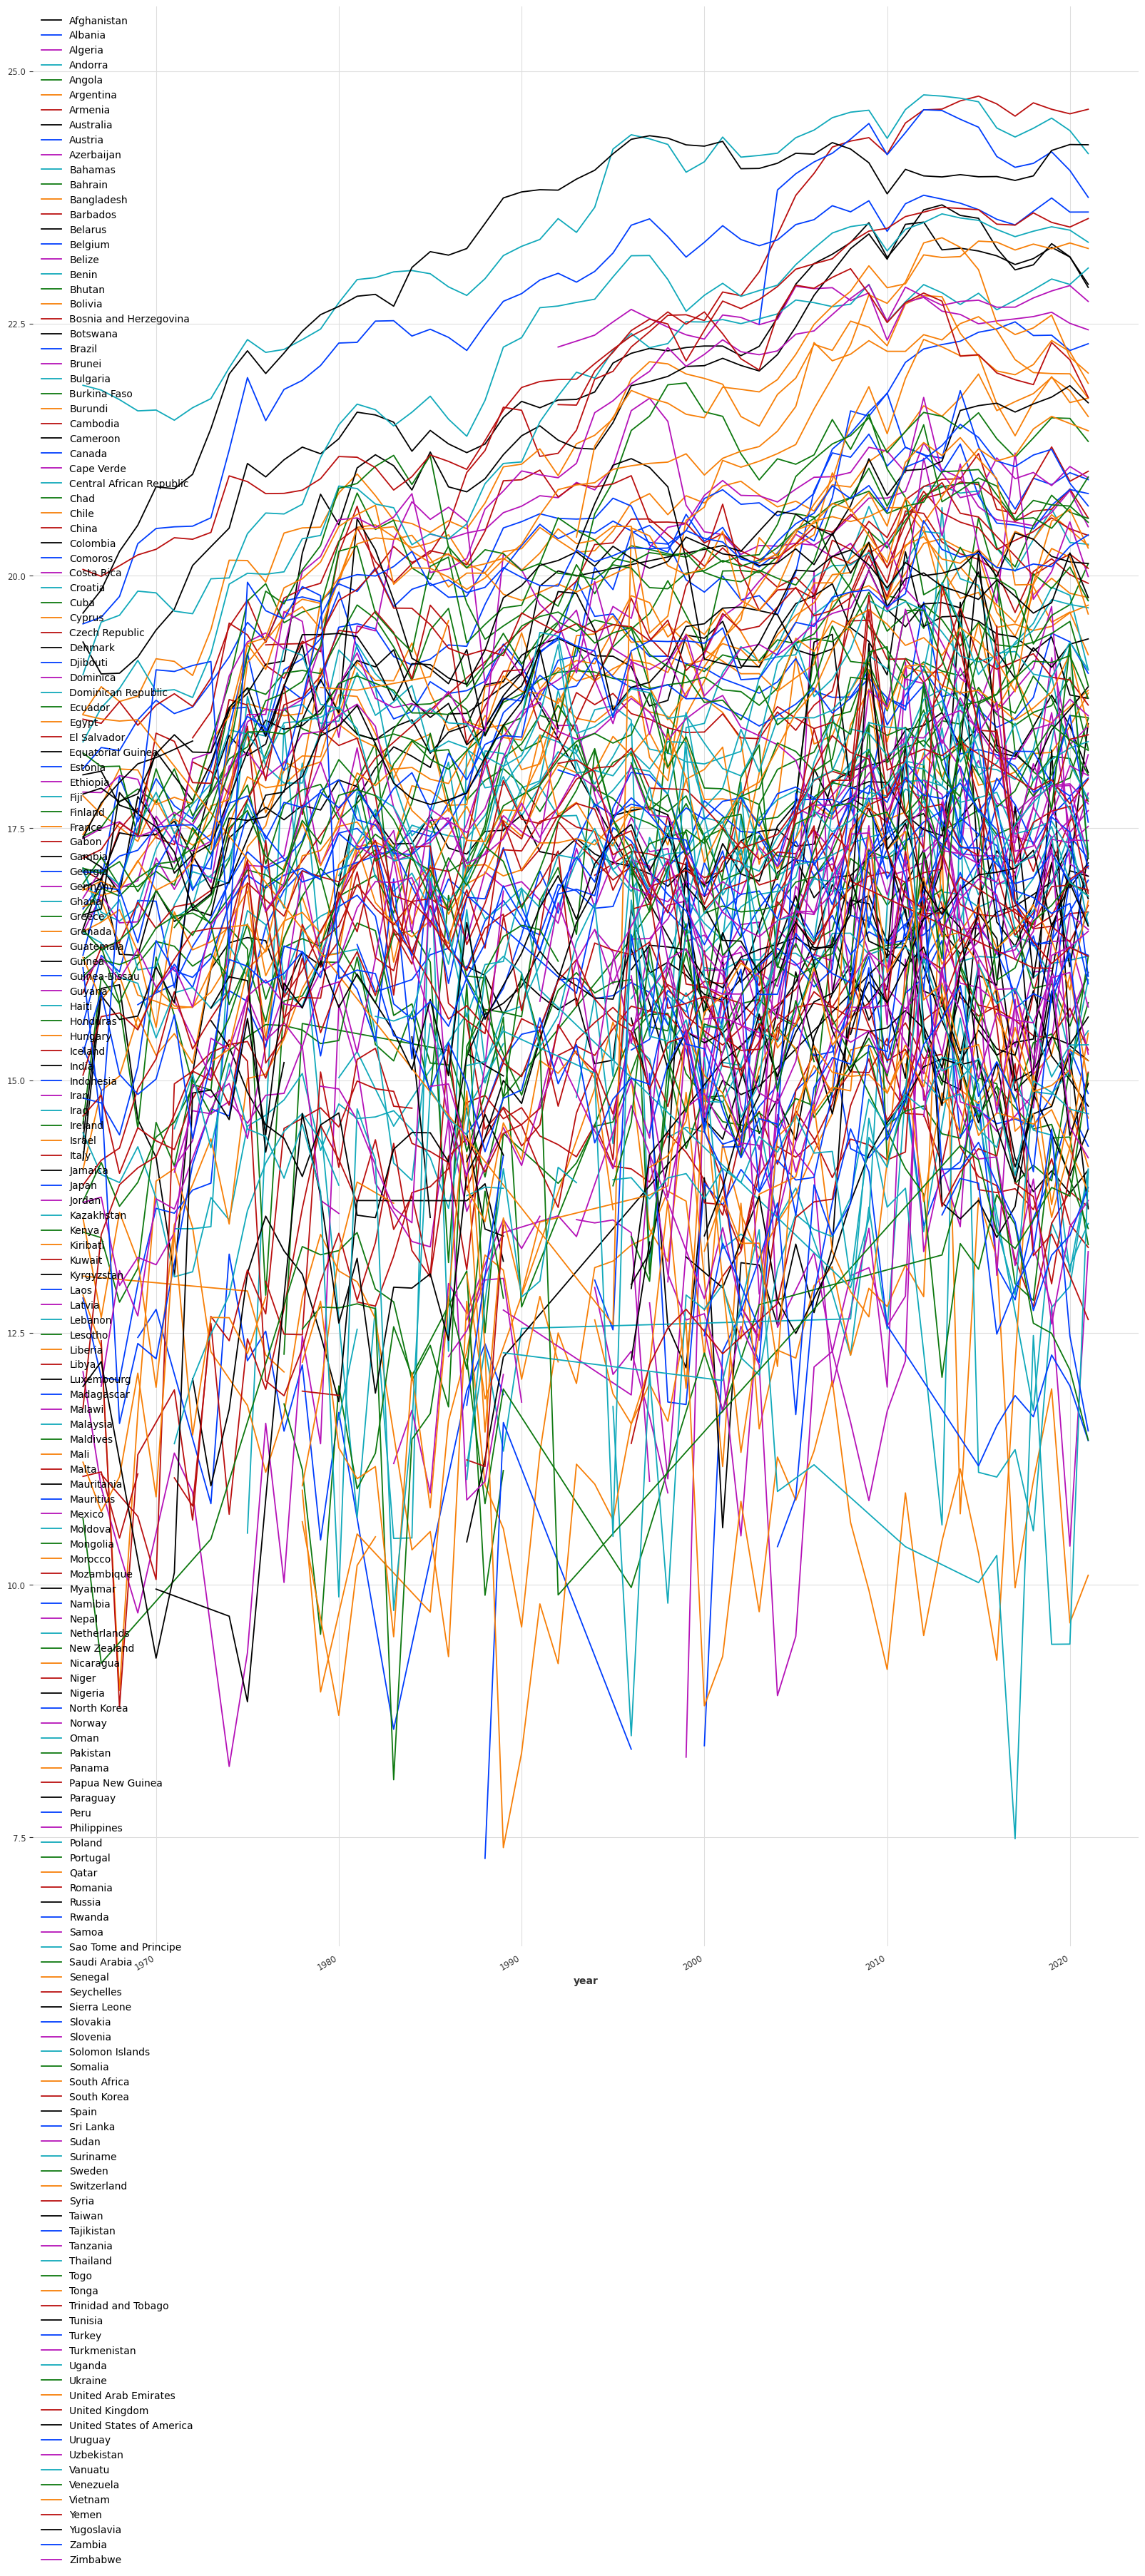

In [15]:
fig, ax = plt.subplots(figsize=(20, 40))
for key, grp in df.groupby('country_d'):
    ax = grp.plot(ax=ax, kind='line', x='year', y='log_all_exports_new', label=key)
#plt.show()

In [12]:
import darts
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.utils.statistics import plot_acf, plot_pacf
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.models import TCNModel
from darts.models import NBEATSModel
from darts.models import RandomForest
from darts.utils.likelihood_models import GaussianLikelihood
from darts.metrics import mape, mae, rmse, r2_score
from darts.timeseries import concatenate
import torch

In [174]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller

# Define year range
full_years = pd.date_range(start="1989-12-31", end="2020-12-31", freq="YE")
full_years_df = pd.DataFrame({"year": full_years})

# Reformat into Darts TimeSeries objects & Split into train/test sets

# Train-test split based on forecast horizon
forecast_horizon = 1  # Forecast 1 year ahead


# Get the last valid time (latest available year) based on your covariate
last_valid_time = df.set_index("year")['distcap'].last_valid_index()

# Compute the train-test split point: leave the last year for testing
split_point = last_valid_time - pd.DateOffset(years=forecast_horizon)

print(f"Split point: {split_point.year}") 

target_series_dict = {}  #
past_covariates_dict = {}  # 


# Initialize lists for train/test sets
train_series_list = []
test_series_list = []
past_covariates_list = []
country_list = []

# need to inspect all countries and remove those with very few observations
df = df[df["country_d"] != "Taiwan"]
df = df[df["country_d"] != "North Korea"]

for country in df['country_d'].unique():

    country_list.append(country)
    
    # Filter for the current country
    df_country = df[df['country_d'] == country].copy()

    # Step 3: Merge with full years to ensure all dates are present
    df_country = pd.merge(full_years_df, df_country, on="year", how="left")

    # Drop duplicates of rows (see Germany, which part of cleaning went wrong?)
    df_country = df_country.drop_duplicates(subset=["year"], keep="first")

    #Impute missing value
    df_country["log_all_exports_new"] = (
    df_country["log_all_exports_new"]
    .interpolate(method="linear", limit_direction="both")  # fills middle
    .ffill()  # fills head
    .bfill()  # fills tail
    )
    
    # Create TimeSeries objects
    target_series = TimeSeries.from_dataframe(df_country, time_col="year", value_cols=['log_all_exports_new'])
    past_covariates = TimeSeries.from_dataframe(df_country, time_col="year", 
                                                  value_cols=['geopolitical_closeness_index_fa', 'distcap', 'gdpcap_d', 'pop_d'])
    
    train_series, test_series = target_series.split_after(split_point)

    train_series_filled = imputer.transform(train_series)
    test_series_filled = imputer.transform(test_series)

    # Convert to float32 for Darts compatibility
    train_series_list.append(train_series_filled.astype(np.float32))
    test_series_list.append(test_series_filled.astype(np.float32))
    past_covariates_list.append(past_covariates.astype(np.float32))

Split point: 2019


In [115]:
print(len(train_series_list))
print(len(train_series_list[2]))
print(len(test_series_list))
print(len(test_series_list[0]))

171
31
171
1


<Axes: xlabel='year'>

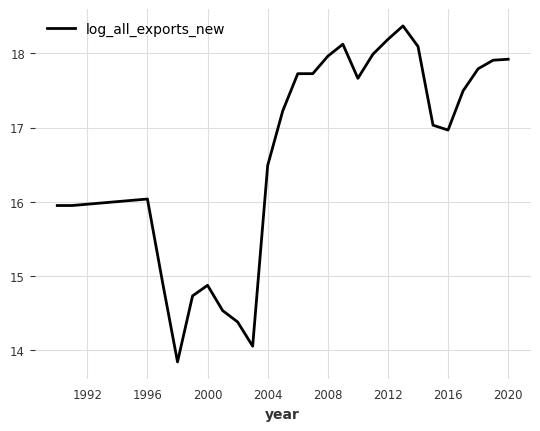

In [145]:
train_series_list[163].plot()

ValueError: max_lag must be greater than or equal to 1 and less than len(ts)//2.


ValueError: max_lag must be greater than or equal to 1 and less than len(ts)//2.

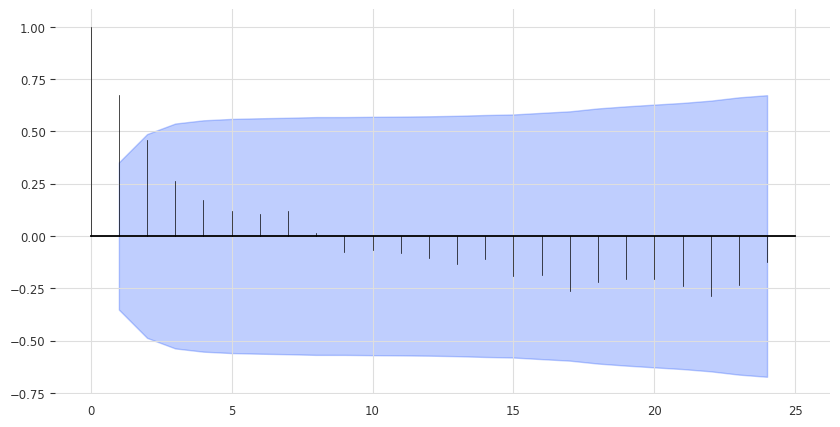

In [125]:
series = train_series_list[8]
plot_acf(series)
plot_pacf(series)

In [177]:
predictions_dict = {}  # Country name -> prediction (predicts 2020)

for i, country in enumerate(df['country_d'].unique()):
    train_series = train_series_list[i]
    past_covariates = past_covariates_list[i]

    model = RandomForest(
        lags=[-1, -2, -3],
        lags_past_covariates=[-1, -2, -3],
        output_chunk_length=1
        #model_kwargs={"n_estimators": 200, "max_depth": 8, "random_state": 42}
    )

    #if train_series.pd_dataframe().isna().sum().sum() > 0:
        #print(f"NaNs found in train_series for {country}")
        #continue

    model.fit(series=train_series, past_covariates=past_covariates)

    pred = model.predict(n=1, series=train_series, past_covariates=past_covariates)
    
    predictions_dict[country] = pred

for country, pred in predictions_dict.items():
    print(f"{country}: {pred.values()[0][0]}")

Afghanistan: 17.04532691001892
Angola: 18.050210971832275
Albania: 13.86639711380005
Andorra: 13.696615266799927
United Arab Emirates: 22.098754806518556
Argentina: 18.780106620788573
Armenia: 13.748714208602905
Australia: 23.148876819610596
Austria: 19.082514572143555
Azerbaijan: 17.580610218048097
Burundi: 11.106359786987305
Belgium: 22.342757892608642
Benin: 15.696390914916993
Burkina Faso: 14.393505544662476
Bangladesh: 21.847016506195068
Bulgaria: 18.82457302093506
Bahrain: 18.678592796325685
Bahamas: 20.382159023284913
Bosnia and Herzegovina: 13.974814612315251
Belarus: 14.117769031524658
Belize: 15.622160596847534
Bolivia: 15.82299674987793
Brazil: 20.83740339279175
Barbados: 16.407044019699097
Brunei: 20.911812210083006
Bhutan: 15.531530027389527
Botswana: 16.631084299087526
Central African Republic: 12.955072078704834
Canada: 20.942069396972656
Switzerland: 21.305392742156982
Chile: 18.399081745147704
China: 24.64073865890503
Cameroon: 16.99301290512085
Colombia: 18.5241141319

In [178]:
from sklearn.metrics import mean_absolute_error

actual_vs_predicted = {}

for i, country in enumerate(df['country_d'].unique()):
    if country not in predictions_dict:
        continue  # skip if this country was skipped during prediction

    pred_series = predictions_dict[country]  # TimeSeries object
    actual_series = test_series_list[i]      # TimeSeries object
    
    if len(actual_series) == 0:
        print(f"No test data for {country}")
        continue
    
    # Extract scalar values
    y_true = actual_series.values()[0][0]      # First test value
    y_pred = pred_series.values()[0][0]        # First forecast

    error = abs(y_pred - y_true)               # Absolute error (or you can square it for MSE)
    
    actual_vs_predicted[country] = {
        "actual": y_true,
        "predicted": y_pred,
        "error": error
    }

for country, results in actual_vs_predicted.items():
    print(f"{country} - Actual: {results['actual']:.3f}, Predicted: {results['predicted']:.3f}, Error: {results['error']:.3f}")


Afghanistan - Actual: 16.799, Predicted: 17.045, Error: 0.246
Angola - Actual: 18.585, Predicted: 18.050, Error: 0.535
Albania - Actual: 14.347, Predicted: 13.866, Error: 0.481
Andorra - Actual: 13.581, Predicted: 13.697, Error: 0.115
United Arab Emirates - Actual: 21.760, Predicted: 22.099, Error: 0.339
Argentina - Actual: 18.865, Predicted: 18.780, Error: 0.085
Armenia - Actual: 13.745, Predicted: 13.749, Error: 0.003
Australia - Actual: 22.857, Predicted: 23.149, Error: 0.292
Austria - Actual: 19.033, Predicted: 19.083, Error: 0.049
Azerbaijan - Actual: 17.845, Predicted: 17.581, Error: 0.265
Burundi - Actual: 10.095, Predicted: 11.106, Error: 1.011
Belgium - Actual: 22.299, Predicted: 22.343, Error: 0.044
Benin - Actual: 15.491, Predicted: 15.696, Error: 0.205
Burkina Faso - Actual: 15.770, Predicted: 14.394, Error: 1.377
Bangladesh - Actual: 21.578, Predicted: 21.847, Error: 0.269
Bulgaria - Actual: 17.232, Predicted: 18.825, Error: 1.593
Bahrain - Actual: 18.283, Predicted: 18.67

In [150]:
all_actuals = [v['actual'] for v in actual_vs_predicted.values()]
all_preds = [v['predicted'] for v in actual_vs_predicted.values()]

mae = mean_absolute_error(all_actuals, all_preds)

print(f"\nOverall Mean Absolute Error: {mae:.4f}")


Overall Mean Absolute Error: 0.4646


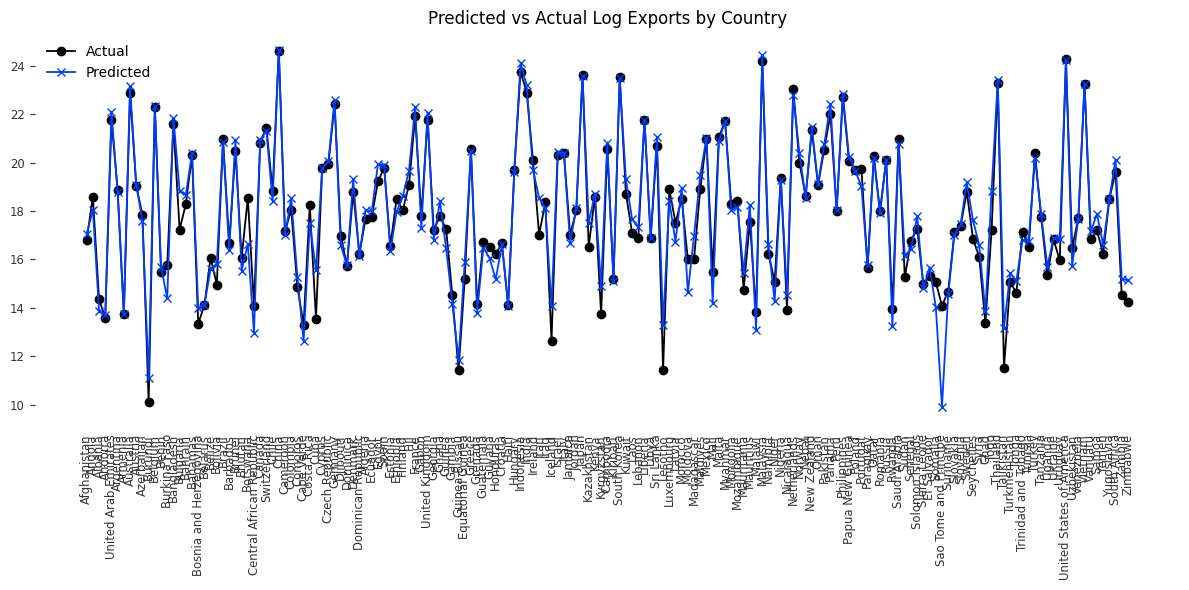

In [179]:
import matplotlib.pyplot as plt

countries = list(actual_vs_predicted.keys())
actual = [actual_vs_predicted[c]['actual'] for c in countries]
predicted = [actual_vs_predicted[c]['predicted'] for c in countries]

plt.figure(figsize=(12, 6))
plt.plot(countries, actual, label="Actual", marker='o')
plt.plot(countries, predicted, label="Predicted", marker='x')
plt.xticks(rotation=90)
plt.title("Predicted vs Actual Log Exports by Country")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [180]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract predictions and ground truth values
all_actuals = [v['actual'] for v in actual_vs_predicted.values()]
all_preds = [v['predicted'] for v in actual_vs_predicted.values()]

# Compute MSE
mse = mean_squared_error(all_actuals, all_preds)

# Compute RMSE
rmse = np.sqrt(mse)

# Print results
print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")



Mean Squared Error (MSE): 0.4625
Root Mean Squared Error (RMSE): 0.6801


In [181]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Dictionary to store per-country evaluation metrics
metrics_by_country = {}

# Per-country metrics
for country, results in actual_vs_predicted.items():
    y_true = results['actual']
    y_pred = results['predicted']
    
    mse = (y_true - y_pred) ** 2
    rmse = np.sqrt(mse)
    r2 = r2_score([y_true], [y_pred])  # single-value R² returns 1.0 by definition
    mape = mean_absolute_percentage_error([y_true], [y_pred])
    
    metrics_by_country[country] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

# Print per-country metrics
print("📊 Per-country Metrics:")
for country, metrics in metrics_by_country.items():
    print(f"{country}: MSE={metrics['MSE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R2']:.4f}, MAPE={metrics['MAPE']*100:.2f}%")

# Aggregate global metrics (averaged)
all_mse = [m['MSE'] for m in metrics_by_country.values()]
all_rmse = [m['RMSE'] for m in metrics_by_country.values()]
all_r2 = [m['R2'] for m in metrics_by_country.values()]
all_mape = [m['MAPE'] for m in metrics_by_country.values()]

avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)
avg_r2 = np.mean(all_r2)
avg_mape = np.mean(all_mape)

print("\n🌍 Global Average Metrics:")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average R²: {avg_r2:.4f}")
print(f"Average MAPE: {avg_mape*100:.2f}%")


📊 Per-country Metrics:
Afghanistan: MSE=0.0606, RMSE=0.2461, R²=nan, MAPE=1.47%
Angola: MSE=0.2864, RMSE=0.5352, R²=nan, MAPE=2.88%
Albania: MSE=0.2313, RMSE=0.4810, R²=nan, MAPE=3.35%
Andorra: MSE=0.0133, RMSE=0.1155, R²=nan, MAPE=0.85%
United Arab Emirates: MSE=0.1150, RMSE=0.3392, R²=nan, MAPE=1.56%
Argentina: MSE=0.0072, RMSE=0.0846, R²=nan, MAPE=0.45%
Armenia: MSE=0.0000, RMSE=0.0033, R²=nan, MAPE=0.02%
Australia: MSE=0.0851, RMSE=0.2917, R²=nan, MAPE=1.28%
Austria: MSE=0.0024, RMSE=0.0492, R²=nan, MAPE=0.26%
Azerbaijan: MSE=0.0701, RMSE=0.2648, R²=nan, MAPE=1.48%
Burundi: MSE=1.0220, RMSE=1.0109, R²=nan, MAPE=10.01%
Belgium: MSE=0.0019, RMSE=0.0439, R²=nan, MAPE=0.20%
Benin: MSE=0.0422, RMSE=0.2054, R²=nan, MAPE=1.33%
Burkina Faso: MSE=1.8951, RMSE=1.3766, R²=nan, MAPE=8.73%
Bangladesh: MSE=0.0725, RMSE=0.2693, R²=nan, MAPE=1.25%
Bulgaria: MSE=2.5363, RMSE=1.5926, R²=nan, MAPE=9.24%
Bahrain: MSE=0.1561, RMSE=0.3951, R²=nan, MAPE=2.16%
Bahamas: MSE=0.0050, RMSE=0.0707, R²=nan, MAP

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Library/Frameworks/Pyth

In [182]:
from darts.models import RandomForest

predictions_dict = {}  # Country name -> 2021 forecast

# Use safe lag configs (e.g. past 3 years)
lags = [-1, -2, -3]
lags_cov = [-1, -2, -3]

for i, country in enumerate(country_list):  # use pre-cleaned country_list

    series = train_series_list[i]  # up to 2020
    covariates = past_covariates_list[i]  # must match index and go to 2020

    # Train model on full series
    model = RandomForest(
        lags=lags,
        lags_past_covariates=lags_cov,
        output_chunk_length=1,
        n_jobs=-1
    )

    try:
        model.fit(series=series, past_covariates=covariates)

        # Forecast 1 step into the future (2021)
        forecast = model.predict(n=1, series=series, past_covariates=covariates)

        predictions_dict[country] = forecast
    except Exception as e:
        print(f"{country}: Forecasting failed → {e}")
        continue

# Print the forecasts for 2021
for country, pred in predictions_dict.items():
    val = pred.values()[0][0]
    print(f"{country} - Forecasted log(exports) for 2021: {val:.4f}")


Afghanistan - Forecasted log(exports) for 2021: 17.0762
Angola - Forecasted log(exports) for 2021: 18.0375
Albania - Forecasted log(exports) for 2021: 13.6299
Andorra - Forecasted log(exports) for 2021: 13.8692
United Arab Emirates - Forecasted log(exports) for 2021: 22.1343
Argentina - Forecasted log(exports) for 2021: 18.8264
Armenia - Forecasted log(exports) for 2021: 13.8811
Australia - Forecasted log(exports) for 2021: 23.1881
Austria - Forecasted log(exports) for 2021: 19.1156
Azerbaijan - Forecasted log(exports) for 2021: 17.6576
Burundi - Forecasted log(exports) for 2021: 10.7360
Belgium - Forecasted log(exports) for 2021: 22.3347
Benin - Forecasted log(exports) for 2021: 15.6958
Burkina Faso - Forecasted log(exports) for 2021: 14.4452
Bangladesh - Forecasted log(exports) for 2021: 21.8516
Bulgaria - Forecasted log(exports) for 2021: 18.7693
Bahrain - Forecasted log(exports) for 2021: 18.6018
Bahamas - Forecasted log(exports) for 2021: 20.4158
Bosnia and Herzegovina - Forecaste

In [190]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Define rolling window parameters
training_window_size = 10  # Number of years in the training set
forecast_horizon = 1  # Forecast 1 year ahead
rolling_predictions_dict = {}  # To store the rolling predictions for each country

# Rolling Window Cross-Validation
for country in df['country_d'].unique():
    country_list.append(country)
    
    # Filter for the current country
    df_country = df[df['country_d'] == country].copy()

    # Merge with full years to ensure all dates are present
    df_country = pd.merge(full_years_df, df_country, on="year", how="left")
    df_country = df_country.drop_duplicates(subset=["year"], keep="first")

    # Impute missing values
    df_country["log_all_exports_new"] = (
        df_country["log_all_exports_new"]
        .interpolate(method="linear", limit_direction="both")
        .ffill()
        .bfill()
    )

    # Create TimeSeries objects
    target_series = TimeSeries.from_dataframe(df_country, time_col="year", value_cols=['log_all_exports_new'])
    past_covariates = TimeSeries.from_dataframe(df_country, time_col="year", 
                                                value_cols=['geopolitical_closeness_index_fa', 'distcap', 'gdpcap_d', 'pop_d'])

    # Initialize rolling prediction list and actuals
    rolling_predictions = []
    actuals = []

    # Loop through the time series using a rolling window approach
    for start_year in range(1989, 2020 - training_window_size + 1):  # until 2020 - training window size
        train_start = start_year
        train_end = start_year + training_window_size - 1  # Training set ends after the training window size
        
        test_start = train_end + 1
        test_end = test_start + forecast_horizon - 1  # Test for 1 year ahead

        # Select the training and testing sets
        train_series = target_series.slice(slice(pd.Timestamp(f'{train_start}-12-31'), pd.Timestamp(f'{train_end}-12-31')))
        test_series = target_series.slice(slice(pd.Timestamp(f'{test_start}-12-31'), pd.Timestamp(f'{test_end}-12-31')))
        
        past_covariates_train = past_covariates.slice(slice(pd.Timestamp(f'{train_start}-12-31'), pd.Timestamp(f'{train_end}-12-31')))
        past_covariates_test = past_covariates.slice(slice(pd.Timestamp(f'{test_start}-12-31'), pd.Timestamp(f'{test_end}-12-31')))
        
        # Fit the model on the training data
        model = RandomForest(
            lags=[-1, -2, -3],
            lags_past_covariates=[-1, -2, -3],
            output_chunk_length=1
        )
        model.fit(series=train_series, past_covariates=past_covariates_train)

        # Forecast the next year (1 step ahead)
        pred = model.predict(n=forecast_horizon, series=train_series, past_covariates=past_covariates_test)
        
        # Store the actual and predicted values for evaluation
        rolling_predictions.append(pred.values()[0][0])
        actuals.append(test_series.values()[0][0])
    
    # Evaluate the model's performance using Mean Squared Error or other metrics
    rolling_predictions_dict[country] = rolling_predictions
    mse = mean_squared_error(actuals, rolling_predictions)
    print(f"Rolling MSE for {country}: {mse:.4f}")

# Optionally: Print the predictions for each country
#for country, predictions in rolling_predictions_dict.items():
    #print(f"Predictions for {country}: {predictions}")


TypeError: TimeSeries.slice() missing 1 required positional argument: 'end_ts'

In [191]:
# Rolling Window Cross-Validation
for country in df['country_d'].unique():
    country_list.append(country)
    
    # Filter for the current country
    df_country = df[df['country_d'] == country].copy()

    # Merge with full years to ensure all dates are present
    df_country = pd.merge(full_years_df, df_country, on="year", how="left")
    df_country = df_country.drop_duplicates(subset=["year"], keep="first")

    # Impute missing values
    df_country["log_all_exports_new"] = (
        df_country["log_all_exports_new"]
        .interpolate(method="linear", limit_direction="both")
        .ffill()
        .bfill()
    )

    # Create TimeSeries objects
    target_series = TimeSeries.from_dataframe(df_country, time_col="year", value_cols=['log_all_exports_new'])
    past_covariates = TimeSeries.from_dataframe(df_country, time_col="year", 
                                                value_cols=['geopolitical_closeness_index_fa', 'distcap', 'gdpcap_d', 'pop_d'])

    # Initialize rolling prediction list and actuals
    rolling_predictions = []
    actuals = []

    # Loop through the time series using a rolling window approach
    for start_year in range(1989, 2020 - training_window_size + 1):  # until 2020 - training window size
        train_start = pd.Timestamp(f'{start_year}-12-31')
        train_end = pd.Timestamp(f'{start_year + training_window_size - 1}-12-31')  # Training set ends after the training window size
        
        test_start = train_end + pd.DateOffset(days=1)  # Test starts the day after the training set
        test_end = test_start + pd.DateOffset(years=forecast_horizon - 1)  # Test for 1 year ahead

        # Select the training and testing sets
        train_series = target_series.slice(start_ts=train_start, end_ts=train_end)
        test_series = target_series.slice(start_ts=test_start, end_ts=test_end)
        
        past_covariates_train = past_covariates.slice(start_ts=train_start, end_ts=train_end)
        past_covariates_test = past_covariates.slice(start_ts=test_start, end_ts=test_end)
        
        # Fit the model on the training data
        model = RandomForest(
            lags=[-1, -2, -3],
            lags_past_covariates=[-1, -2, -3],
            output_chunk_length=1
        )
        model.fit(series=train_series, past_covariates=past_covariates_train)

        # Forecast the next year (1 step ahead)
        pred = model.predict(n=forecast_horizon, series=train_series, past_covariates=past_covariates_test)
        
        # Store the actual and predicted values for evaluation
        rolling_predictions.append(pred.values()[0][0])
        actuals.append(test_series.values()[0][0])
    
    # Evaluate the model's performance using Mean Squared Error or other metrics
    rolling_predictions_dict[country] = rolling_predictions
    mse = mean_squared_error(actuals, rolling_predictions)
    print(f"Rolling MSE for {country}: {mse:.4f}")

# Optionally: Print the predictions for each country
for country, predictions in rolling_predictions_dict.items():
    print(f"Predictions for {country}: {predictions}")


IndexError: index 0 is out of bounds for axis 0 with size 0